<a href="https://colab.research.google.com/github/Utkarsh87/Capsule-Networks/blob/master/CapsNet%20MNIST%20v2.0.2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [0]:
import numpy as np
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [103]:
tf.__version__

'2.2.0'

In [0]:
tf.compat.v1.enable_eager_execution()

In [105]:
tf.executing_eagerly()

True

In [0]:
tf.compat.v1.reset_default_graph()

Load in MNIST data

In [107]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
print(train_images.shape)

val_images = train_images[50000:]
val_labels = train_labels[50000:]

train_images = train_images[:50000]
train_labels = train_labels[:50000]

(60000, 28, 28)


Visualise a few of the MNIST images

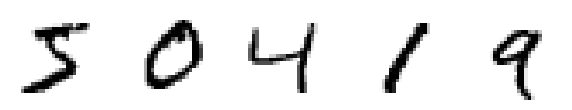

In [108]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = train_images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

# Primary Capsules

**Define the conv layers of the network.**

In [0]:
from tensorflow.keras.layers import Conv2D, Dense
conv_layer1 = Conv2D(256, (9, 9), strides=(1, 1), input_shape=(None, 28, 28, 1))
conv_layer2 = Conv2D(256, (9, 9), strides=(2, 2), input_shape=(None, 20, 20, 256))

In [110]:
# reshape and rescale
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
train_images = train_images*1.0/255.0

val_images = val_images.reshape((val_images.shape[0], 28, 28, 1))
val_images = val_images*1.0/255.0

# batch training and validation needed due to high number of samples
batch_size = 64
num_training_batches = train_images.shape[0]//batch_size
num_val_batches = val_images.shape[0]//batch_size

print(num_training_batches, num_val_batches)

781 156


In [0]:
def relu_conv(x):
  op = conv_layer1(x)
  return op

In [0]:
def primary_caps_conv(x):
  op = conv_layer2(x)
  return op

**Now we need to squash the vectors**

In [0]:
def squash(s, axis=-1, epsilon=1e-7):
  
    squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=True)
    safe_squared_norm = tf.sqrt(squared_norm + epsilon)
    squash_factor = squared_norm / (1. + squared_norm)
    unit_vector = s / safe_squared_norm

    return squash_factor * unit_vector

Now we have the outputs from the Primary capsule layer(child layer) ready, to comoute the output of the next capule layer, i.e., the DigiCaps layer(parent layer), we need to get the predicted output vectors(one for each child/parent capsule pair). After having the predicted output vectors ready we can run the routing-by-agreement algorithm.

# Digit Capsules

**Compute the predicted output vectors**

The DigiCaps layer will contain 10 capsules(one for each digit), each a 16-dimensional vector. Hence the transformation matrix Wij has a shape (16, 8)


To get the predicted vectors, need to multiply the output of the primary capsule layers with the transformation matrices. The output of this matmul will be how the output of a capsule in the child layer relates spatially with the capsule in the parent layer.

In [114]:
# Primary capsule layer; number of capsules and dimensionality of each capsule
caps1_n_caps = 1152 
caps1_n_dims = 8

# Digit capsule layer; number of capsules and dimensionality of each capsule
caps2_n_caps = 10
caps2_n_dims = 16

# define the weight/transformation matrix as random numbers initially and hopefully it learns the correct weights during the training process.
# TODO: look for a better init for weight matrix.

init_sigma = 0.1

W_init = tf.random.normal(
    shape=(1, caps1_n_caps, caps2_n_caps, caps2_n_dims, caps1_n_dims),
    stddev=init_sigma, dtype=tf.float32, name="W_init")

print(W_init.shape)

(1, 1152, 10, 16, 8)


Since there are "batch_size" number of images in one batch of images, need to replicate the values in the created weight matrix "batch_size" number of times.

In [0]:
W_tiled = tf.tile(W_init, [batch_size, 1, 1, 1, 1], name="W_tiled") # replicate only along the first dimension, hence kept others 1.

In [116]:
print(W_tiled.shape)
print(type(W_tiled))

(64, 1152, 10, 16, 8)
<class 'tensorflow.python.framework.ops.EagerTensor'>


Looking at a single image: for each child capsule-parent capsule pair(total 1152*10 such pairs) we have (16, 8) transformation matrix.


---


This is true for all the images in the batch, hence "batch_size" is the first dimension.

In [0]:
def tile_caps1_output(caps1_output):
  caps1_output_expanded = tf.expand_dims(caps1_output, -1)
  caps1_output_expanded2 = tf.expand_dims(caps1_output_expanded, 2)
  caps1_output_tiled = tf.tile(caps1_output_expanded2, [1, 1, caps2_n_caps, 1, 1])
  return caps1_output_tiled

Earlier the shape of the primary capsule layer output was(batch_size, 1152, 8).


---


Tiling the output of the primary capsule layer achieves the following:

Earlier there were 1152 8-D vectors as the outputs of primary capsule layer, but since the output from 1 child capsule goes to all the capsules in the parent layer, the output of each child capsule needs to replicated as many times as there are capsules in the parent layer. This is done so that the same output is sent from a child capsule to each of the capsules in the parent layer.

Hence now the outputs from the primary capsule layer are such that there is an output for every (child-capsule, parent-capsule) pair with all the outputs from one particular child capsule being the same.

In [0]:
def caps1_prediction(caps1_output_tiled):
  '''This function generates the child capsule's (here the primary capsule)
  prediction/best guess of what the parent capsule's(here the digit capsule)
  output looks like.'''
  ''' If the predictions of all the child capsules match, then it is said that
  the child capsules are in agreement with the pose/orientation of the parent
  capsule and hence all of them will route their outputs to that particular
  paarent capsule thereafter.
  Hence this predicted output from the primary caps layer is essential to the
  working of the routing-by-agreement algorithm.'''
  
  caps2_predicted = tf.matmul(W_tiled, caps1_output_tiled)
  return caps2_predicted

Progress: We now have, for each (child capsule-parent capsule) pair an 8-D(8, 1) output vector which will be multiplied with a (16, 8) weight/transformation matrix to yield 16-D(16, 1) predicted output vectors.


---
For each instance in the batch, and for each (child capsule-parent capsule) pair, i.e. 1152*10 such pairs(number of capsules in child layer * number of capsules in parent layer)a vector, each of 16 dimensions.


**Routing-by-agreement algorithm**

In [0]:
# define the scalar weights/coefficients that will be tuned during the routing process
raw_weights = tf.zeros([batch_size, caps1_n_caps, caps2_n_caps, 1, 1],
                       dtype=np.float32)
# Following from the original paper, the init of all b_i(read b-sub-i) is to zero

For every sample in the batch, and for each of the (child capsule, parent
capsule) pairs there is a routing weight.
Hence: for every sample in the batch; the number of routing weights is:

number of capsules in the child layer * number of capsules in the parent layer(here = 1152*10).

[Aurelion Geron explains the following step beautifully:](https://github.com/ageron/handson-ml/blob/master/extra_capsnets.ipynb)

There are a couple important details to note here:

To perform elementwise matrix multiplication (also called the Hadamard product, noted $\circ$), we use the tf.multiply() function. It requires routing_weights and caps2_predicted to have the same rank, which is why we added two extra dimensions of size 1 to routing_weights, earlier.


---


The shape of routing_weights is (batch size, 1152, 10, 1, 1) while the shape of caps2_predicted is (batch size, 1152, 10, 16, 1). Since they don't match on the fourth dimension (1 vs 16), tf.multiply() automatically broadcasts the routing_weights 16 times along that dimension.

In [0]:
def get_weighted_sum(caps2_predicted, routing_weights):
  weighted_predictions = tf.multiply(routing_weights, caps2_predicted)
  weighted_sum = tf.reduce_sum(weighted_predictions, axis=1, keepdims=True)
  return weighted_sum

# Estimate class probabilities(Length of the output vectors)

In [0]:
def safe_norm(s, axis=-1, epsilon=1e-8, keepdims=False):
    squared_norm = tf.reduce_sum(tf.square(s), axis=axis, keepdims=keepdims)
    return tf.sqrt(squared_norm + epsilon)

# Margin loss

In [0]:
m_plus = 0.9
m_minus = 0.1
lambda_ = 0.5

In [0]:
def margin_loss(caps2_output, T):
  caps2_output_norm = safe_norm(caps2_output, axis=-2, keepdims=True)
  present_error_raw = tf.square(tf.maximum(0., m_plus-caps2_output_norm))
  present_error = tf.reshape(present_error_raw, shape=(-1, 10))
  absent_error_raw = tf.square(tf.maximum(0., caps2_output_norm-m_minus))
  absent_error = tf.reshape(absent_error_raw, shape=(-1, 10))
  # compute the loss for each instance and each digit
  loss_temp = tf.add(T*present_error, lambda_*(1.0-T)*absent_error)
  # compute mean loss over all instances
  loss_final = tf.reduce_mean(tf.reduce_sum(loss_temp, axis=1))
  return loss_final

In [127]:
routing_iterations = 3 # minimum advisable
epochs = 5
train_loss = []

num_training_batches = 10 # force it to a lesser value for debugging

for i in range(num_training_batches):
  # TRAINING PASS

  # Create the input batch
  ip = train_images[i*batch_size : (i+1)*batch_size]

  # Feed to ReLU CONV1
  intermediate_op = relu_conv(ip)
  # Feed to Primary Capsule Layer
  op = primary_caps_conv(intermediate_op)

  # Reshape
  op = tf.reshape(op, [batch_size, 1152, 8])  

  # Squash the op of primary caps layer to get raw primary caps output
  caps1_output = squash(op)

  # Tile(replicate) the output of primary capsule layer
  caps1_output_tiled = tile_caps1_output(caps1_output)

  # Get the PrimaryCaps layer's prediction of the DigitCaps layer's output.
  caps2_predicted = caps1_prediction(caps1_output_tiled)

  # ********************************************************************
  # ******************** START DYNAMIC ROUTING *************************
  # ********************************************************************

  for route_iter in range(routing_iterations):
    # Softmax
    routing_weights = tf.nn.softmax(raw_weights, axis=2, name="routing_weights")
    weighted_sum = get_weighted_sum(caps2_predicted, routing_weights)

    caps2_output = squash(weighted_sum, axis=-2)
    if route_iter < routing_iterations:
      # For the shapes to match, need to tile the caps2_output 1152 times.
      caps2_output_tiled = tf.tile(caps2_output,
                                   [1, caps1_n_caps, 1, 1, 1])
      # calculate the agreement
      agreement = tf.linalg.matmul(caps2_predicted, caps2_output_tiled, 
                                  transpose_a=True, name="agreement")
      # Agreement is used to update the raw weights for next iteration.
      raw_weights = tf.add(raw_weights, agreement)

  # ********************************************************************
  # ********************* END OF DYNAMIC ROUTING ***********************
  # ********************************************************************

  # Estimate class probabilities(length of the output vectors).
  # The output vector with the greatest length is the class/label predicted
  # by the dynamic routing algorithm.
  y_prob = safe_norm(caps2_output, axis=-2)
  # Get the final prediction
  _argmax = tf.argmax(y_prob, axis=-2)
  y_pred = tf.squeeze(_argmax, axis=[1, 2])
  # holds the predictions for each image in the batch.

  # create one-hot labels for the 10 digit classes
  indices = train_labels[i*batch_size : (i+1)*batch_size]
  depth = 10
  T = tf.one_hot(indices, depth)

  caps_net_loss = margin_loss(caps2_output, T)
  # TODO: BACKPROP !!
  train_loss.append(caps_net_loss.numpy())

  # VALIDATION PASS

print(np.mean(train_loss))

0.8087934
